# Import and pre-definitions

In [1]:
import os
MAIN_PATH = r'/home/luis-felipe'
DATA_PATH = os.path.join(MAIN_PATH,'data')
PATH_MODELS = os.path.join(MAIN_PATH,'torch_models')
FIGS_PATH = os.path.join(MAIN_PATH,'results','figs')

In [2]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Define o computador utilizado como cuda (gpu) se existir ou cpu caso contrário
print(torch.cuda.is_available())
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.set_default_dtype(torch.float64)
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

True


In [4]:
import sys
sys.path.insert(1, '..')
sys.path.insert(1, '../..')

import models
from utils import measures,metrics
from data_utils import upload_logits, split_data
import post_hoc
from collections import defaultdict

# Evaluate logits

In [5]:
MODEL_ARC = 'VGG_19'
DATASET = 'Cifar100'

In [6]:
logits,labels = upload_logits(MODEL_ARC,DATASET,PATH_MODELS, 
                            split = 'test', device = dev)

# Experiments

In [7]:
VAL_SIZE = 0.1 #Size of total hold-out samples 0.1 = 5000)
N_SPLITS_VAL_TEST = 50 #number of experiments of different splits of validation and test
N_SPLIT_SUB_VAL = 1 #How many experiments for each random subset of the holdout
SIZES_SUB = np.arange(0.025,1.01,0.025) #Hold-out sizes

METRIC = metrics.N_AURC

In [8]:
1 / 0.025

40.0

In [9]:
%%time

exp_1 = []
exp_1_opt = defaultdict(list)
seed1 = SEED
seed2 = 1
for r1 in range(N_SPLITS_VAL_TEST):
    print(r1)
    logits_val,labels_val,logits_test,labels_test = split_data.split_logits(logits,labels,VAL_SIZE,seed=seed1)
    loss_test = measures.wrong_class(logits_test,labels_test).float()

    exp_1_opt['baseline'].append(METRIC(loss_test,measures.MSP(logits_test)))
    exp_1_opt['T'].append(METRIC(loss_test,measures.MSP(logits_test.div(post_hoc.optimize.T(logits_test,loss_test)))))
    exp_1_opt['p'].append(METRIC(loss_test,post_hoc.MaxLogit_p(logits_test,risk = loss_test)))
    exp_1_opt['MSP-p'].append(METRIC(loss_test,post_hoc.MSP_p(logits_test,risk = loss_test)))
    exp_1_opt['LogitsMargin'].append(METRIC(loss_test,measures.margin_logits(logits_test)))
    #exp_1_opt['LogitsMargin-pNorm'].append(METRIC(loss_test,measures.margin_logits(logits_test)))
    exp_1_opt['MSP-2'].append(METRIC(loss_test,post_hoc.MSP_p(logits_test,risk = loss_test,p_range = [2])))

    exp_2 = []
    for r2 in range(N_SPLIT_SUB_VAL):
        print(f'{r1}.{r2}')
        exp_3 = defaultdict(list)
        for val_size_sub in SIZES_SUB:
            N = labels_val.size(0)
            logits_sub,labels_sub =logits_val[:int(val_size_sub*N)],labels_val[:int(val_size_sub*N)]#= split_data.split_logits(logits_val,labels_val,val_size_sub,seed = seed2)[:2]
            loss_sub = measures.wrong_class(logits_sub,labels_sub).float()
            exp_3['T'].append(METRIC(loss_test,measures.MSP(logits_test.div(post_hoc.optimize.T(logits_sub,loss_sub)))))
            p = post_hoc.optimize.p(logits_sub,loss_sub,method = measures.max_logit)
            exp_3['p'].append(METRIC(loss_test,post_hoc.MaxLogit_p(logits_test,p = p)))
            pT = post_hoc.optimize.p_and_beta(logits_sub,loss_sub,method = measures.MSP)
            exp_3['MSP-p'].append(METRIC(loss_test,post_hoc.MSP_p(logits_test,pt = pT)))
            exp_3['LogitsMargin'].append(METRIC(loss_test,measures.margin_logits(logits_test)))
            p = post_hoc.optimize.p(logits_sub,loss_sub,method = measures.max_logit)
            exp_3['LogitsMargin-pNorm'].append(METRIC(loss_test,measures.margin_logits(post_hoc.normalize(logits_test,p=p))))
            
            pT2 = post_hoc.optimize.p_and_beta(logits_sub,loss_sub,method = measures.MSP,p_range = [2])
            exp_3['MSP-2'].append(METRIC(loss_test,post_hoc.MSP_p(logits_test,pt = pT2)))
            
            seed2 += 10
        exp_2.append(exp_3)

    # when val_size_sub is 1.0, there is no need to run the experiment 5 times, since there is only 1 possible split.
    #Thus, the results for 1.0 are calculated separately to save time
    '''loss_val = measures.wrong_class(logits_val,labels_val).float()
    for l in exp_2:
        l['T'].append(METRIC(loss_test,measures.MSP(logits_test.div(post_hoc.optimize.T(logits_val,loss_val)))))
        p = post_hoc.optimize.p(logits_val,loss_val,method = measures.max_logit)
        l['p'].append(METRIC(loss_test,post_hoc.MaxLogit_p(logits_test,p = p)))
        pT = post_hoc.optimize.p_and_beta(logits_val,loss_val,method = measures.MSP)
        l['MSP-p'].append(METRIC(loss_test,post_hoc.MSP_p(logits_test,pt = pT)))
        pT2 = post_hoc.optimize.p_and_beta(logits_sub,loss_sub,method = measures.MSP,p_range = [2])
        l['MSP-2'].append(METRIC(loss_test,post_hoc.MSP_p(logits_test,pt = pT2)))'''
    exp_1.append(exp_2)
    seed1 += 10
    

0
0.0
1
1.0
2
2.0
3
3.0
4
4.0
5
5.0
6
6.0
7
7.0
8
8.0
9
9.0
10
10.0
11
11.0
12
12.0
13
13.0
14
14.0
15
15.0
16
16.0
17
17.0
18
18.0
19
19.0
20
20.0
21
21.0
22
22.0
23
23.0
24
24.0
25
25.0
26
26.0
27
27.0
28
28.0
29
29.0
30
30.0
31
31.0
32
32.0
33
33.0
34
34.0
35
35.0
36
36.0
37
37.0
38
38.0
39
39.0
40
40.0
41
41.0
42
42.0
43
43.0
44
44.0
45
45.0
46
46.0
47
47.0
48
48.0
49
49.0
CPU times: user 24min 5s, sys: 211 ms, total: 24min 5s
Wall time: 24min 5s


In [10]:
import pickle

with open(f'exp_1_dataefficiency_{MODEL_ARC}_{DATASET}.pickle', 'wb') as handle:
    pickle.dump(exp_1, handle, protocol=pickle.HIGHEST_PROTOCOL)
#with open(f'exp_1_dataefficiency_{MODEL_ARC}_{DATASET}.pickle', 'rb') as handle:
#    exp_1 = pickle.load(handle)

In [11]:
#sizes_sub = labels.size(0)*VAL_SIZE*np.r_[SIZES_SUB,1.0]
sizes_sub = labels.size(0)*VAL_SIZE*SIZES_SUB
all_t = []
all_p = []
all_pT = []
all_2T = []
all_LM = []
all_LM_p = []
for r1 in exp_1:
    for r2 in r1:
        all_t.append(r2['T'])
        all_p.append(r2['p'])
        all_pT.append(r2['MSP-p'])
        all_2T.append(r2['MSP-2'])
        all_LM.append(r2['LogitsMargin'])
        all_LM_p.append(r2['LogitsMargin-pNorm'])
all_t = np.array(all_t)
all_p = np.array(all_p)
all_pT = np.array(all_pT)
all_2T = np.array(all_2T)
all_LM = np.array(all_LM)
all_LM_p = np.array(all_LM_p)

In [12]:
means_T = all_t.mean(0)
means_p = all_p.mean(0)
means_pT = all_pT.mean(0)
means_2T = all_2T.mean(0)
means_LM = all_LM.mean(0)
means_LM_p = all_LM_p.mean(0)

std_T = all_t.std(0)
std_p = all_p.std(0)
std_pT = all_pT.std(0)
std_2T = all_2T.std(0)
std_LM = all_LM.std(0)
std_LM_p = all_LM_p.std(0)

min_T = all_t.min(0)
min_p = all_p.min(0)
min_pT = all_pT.min(0)
min_2T = all_2T.min(0)
min_LM = all_LM.min(0)
min_LM_p = all_LM_p.min(0)

max_T = all_t.max(0)
max_p = all_p.max(0)
max_pT = all_pT.max(0)
max_2T = all_2T.max(0)
max_LM = all_LM.max(0)
max_LM_p = all_LM_p.max(0)

baseline_mean = np.mean(exp_1_opt['baseline'])
T_opt_mean = np.mean(exp_1_opt['T'])
p_opt_mean = np.mean(exp_1_opt['p'])
pT_opt_mean = np.mean(exp_1_opt['MSP-p'])
T2_opt_mean = np.mean(exp_1_opt['MSP-2'])
LM_opt_mean = np.mean(exp_1_opt['LogitsMargin'])
#LM_p_opt_mean = np.mean(exp_1_opt['LogitsMargin-pNorm'])

baseline_min = np.min(exp_1_opt['baseline'])
T_opt_min = np.min(exp_1_opt['T'])
p_opt_min = np.min(exp_1_opt['p'])
pT_opt_min = np.min(exp_1_opt['MSP-p'])
T2_opt_min = np.min(exp_1_opt['MSP-2'])
LM_opt_min = np.min(exp_1_opt['LogitsMargin'])
#LM_p_opt_min = np.min(exp_1_opt['LogitsMargin-pNorm'])

baseline_max = np.max(exp_1_opt['baseline'])
T_opt_max = np.max(exp_1_opt['T'])
p_opt_max = np.max(exp_1_opt['p'])
pT_opt_max = np.max(exp_1_opt['MSP-p'])
T2_opt_max = np.max(exp_1_opt['MSP-2'])
LM_opt_max = np.max(exp_1_opt['LogitsMargin'])
#LM_p_opt_max = np.max(exp_1_opt['LogitsMargin-pNorm'])

In [13]:
PERCENTILES = (10,90)
per_T_0 = np.percentile(all_t,PERCENTILES[0],axis=0)
per_p_0 = np.percentile(all_p,PERCENTILES[0],axis=0)
per_pT_0 = np.percentile(all_pT,PERCENTILES[0],axis=0)
per_2T_0 = np.percentile(all_2T,PERCENTILES[0],axis=0)
per_LM_0 = np.percentile(all_LM,PERCENTILES[0],axis=0)
per_LM_p_0 = np.percentile(all_LM_p,PERCENTILES[0],axis=0)

per_T_1 = np.percentile(all_t,PERCENTILES[1],axis=0)
per_p_1 = np.percentile(all_p,PERCENTILES[1],axis=0)
per_pT_1 = np.percentile(all_pT,PERCENTILES[1],axis=0)
per_2T_1 = np.percentile(all_2T,PERCENTILES[1],axis=0)
per_LM_1 = np.percentile(all_LM,PERCENTILES[1],axis=0)
per_LM_p_1 = np.percentile(all_LM_p,PERCENTILES[1],axis=0)

per_T_0_opt = np.percentile(exp_1_opt['T'],PERCENTILES[0],axis=0)
per_p_0_opt = np.percentile(exp_1_opt['p'],PERCENTILES[0],axis=0)
per_pT_0_opt = np.percentile(exp_1_opt['MSP-p'],PERCENTILES[0],axis=0)
per_2T_0_opt = np.percentile(exp_1_opt['MSP-2'],PERCENTILES[0],axis=0)
per_LM_0_opt = np.percentile(exp_1_opt['LogitsMargin'],PERCENTILES[0],axis=0)

per_T_1_opt = np.percentile(exp_1_opt['T'],PERCENTILES[1],axis=0)
per_p_1_opt = np.percentile(exp_1_opt['p'],PERCENTILES[1],axis=0)
per_pT_1_opt = np.percentile(exp_1_opt['MSP-p'],PERCENTILES[1],axis=0)
per_2T_1_opt = np.percentile(exp_1_opt['MSP-2'],PERCENTILES[1],axis=0)
per_LM_1_opt = np.percentile(exp_1_opt['LogitsMargin'],PERCENTILES[1],axis=0)

# Plot

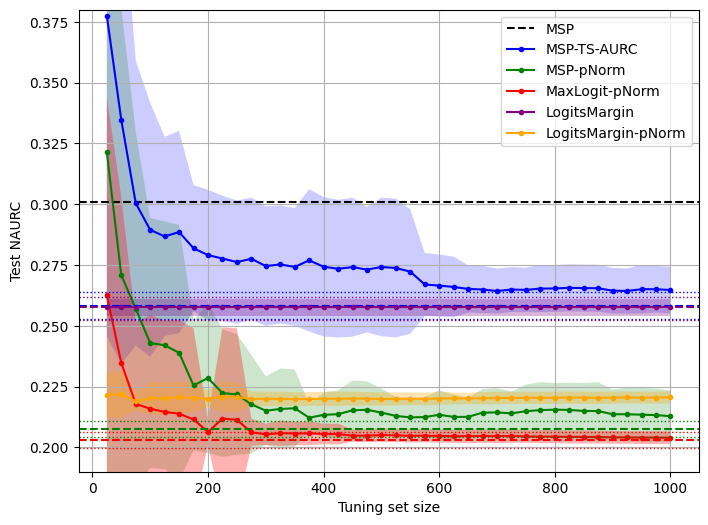

In [14]:
plt.figure(figsize=(8,6))
plt.axhline(baseline_mean,linestyle = '--', color = 'k', label = 'MSP')
T_plot = plt.plot(sizes_sub,means_T,'.-', label = 'MSP-TS-AURC', color = 'blue')
#T2_plot = plt.plot(sizes_sub,means_2T,'.-', label = 'MSP-pNorm (fixed p=2)', color = 'orange')
pT_plot = plt.plot(sizes_sub,means_pT,'.-', label = 'MSP-pNorm', color = 'green')
p_plot = plt.plot(sizes_sub,means_p,'.-', label = 'MaxLogit-pNorm', color = 'red')
LM_plot = plt.plot(sizes_sub,means_LM,'.-', label = 'LogitsMargin', color = 'purple')
LM_p_plot = plt.plot(sizes_sub,means_LM_p,'.-', label = 'LogitsMargin-pNorm', color = 'orange')


#plt.fill_between(sizes_sub, min_p, max_p, facecolor=p_plot[0].get_color(), alpha=0.5)
#plt.fill_between(sizes_sub, min_pT, max_pT, facecolor=pT_plot[0].get_color(), alpha=0.5)


#plt.fill_between(sizes_sub, per_T_0, per_T_1, facecolor=T_plot[0].get_color(), alpha=0.2)
#plt.fill_between(sizes_sub, per_pT_0, per_pT_1, facecolor=pT_plot[0].get_color(), alpha=0.2)
#plt.fill_between(sizes_sub, per_p_0, per_p_1, facecolor=p_plot[0].get_color(), alpha=0.3)
#plt.fill_between(sizes_sub, per_2T_0, per_2T_1, facecolor=T2_plot[0].get_color(), alpha=0.3)
#plt.fill_between(sizes_sub[:-1], per_LM_0, per_LM_1, facecolor=LM_plot[0].get_color(), alpha=0.3)
#plt.fill_between(sizes_sub[:-1], per_LM_p_0, per_LM_p_1, facecolor=LM_p_plot[0].get_color(), alpha=0.3)

plt.fill_between(sizes_sub, means_T-std_T, means_T+std_T, facecolor=T_plot[0].get_color(), alpha=0.2)
plt.fill_between(sizes_sub, means_pT-std_pT, means_pT+std_pT, facecolor=pT_plot[0].get_color(), alpha=0.2)
plt.fill_between(sizes_sub, means_p-std_p, means_p+std_p, facecolor=p_plot[0].get_color(), alpha=0.3)
#plt.fill_between(sizes_sub, per_2T_0, per_2T_1, facecolor=T2_plot[0].get_color(), alpha=0.3)
plt.fill_between(sizes_sub, means_LM-std_LM, means_LM+std_LM, facecolor=LM_plot[0].get_color(), alpha=0.3)
plt.fill_between(sizes_sub, means_LM_p-std_LM_p, means_LM_p+std_LM_p, facecolor=LM_p_plot[0].get_color(), alpha=0.3)


plt.axhline(T_opt_mean,linestyle = '--', color = T_plot[0].get_color())
plt.axhline(p_opt_mean,linestyle = '--', color = p_plot[0].get_color())
plt.axhline(pT_opt_mean,linestyle = '--', color = pT_plot[0].get_color())
#plt.axhline(T2_opt_mean,linestyle = '--', color = T2_plot[0].get_color())
plt.axhline(LM_opt_mean,linestyle = '--', color = LM_plot[0].get_color())
#plt.axhline(LM_p_opt_mean,linestyle = '--', color = LM_p_plot[0].get_color())

plt.axhline(per_pT_0_opt,linestyle = ':', color = pT_plot[0].get_color(),linewidth = 1.0)
plt.axhline(per_pT_1_opt,linestyle = ':', color = pT_plot[0].get_color(),linewidth = 1.0)

plt.axhline(per_T_0_opt,linestyle = ':', color = T_plot[0].get_color(),linewidth = 1.0)
plt.axhline(per_T_1_opt,linestyle = ':', color = T_plot[0].get_color(),linewidth = 1.0)

plt.axhline(per_p_0_opt,linestyle = ':', color = p_plot[0].get_color(),linewidth = 1.0)
plt.axhline(per_p_1_opt,linestyle = ':', color = p_plot[0].get_color(),linewidth = 1.0)

#plt.axhline(per_2T_0_opt,linestyle = ':', color = T2_plot[0].get_color(),linewidth = 1.0)
#plt.axhline(per_2T_1_opt,linestyle = ':', color = T2_plot[0].get_color(),linewidth = 1.0)

plt.axhline(per_LM_0_opt,linestyle = ':', color = LM_plot[0].get_color(),linewidth = 1.0)
plt.axhline(per_LM_1_opt,linestyle = ':', color = LM_plot[0].get_color(),linewidth = 1.0)
#plt.axhline(per_LM_p_0_opt,linestyle = ':', color = LM_p_plot[0].get_color(),linewidth = 1.0)
#plt.axhline(per_LM_p_1_opt,linestyle = ':', color = LM_p_plot[0].get_color(),linewidth = 1.0)

#plt.ylim(0.165,top=0.2)
plt.ylim(0.19,top=0.38)
plt.xlabel('Tuning set size')
plt.ylabel('Test NAURC')
plt.legend()
plt.grid()
plt.savefig(os.path.join(FIGS_PATH, f'DataEfficiency_{MODEL_ARC}_{DATASET}.pdf'), transparent = True, format = 'pdf',bbox_inches = 'tight')
plt.show()

In [15]:
baseline_mean

0.30078556972910203